# Basis embedding (qiskit)

Main steps:

* initialize an image of the sky (frequency domain)
* apply 2D FT --> visibilities (Fourier domain)
* encode visibilities data into qubits using basis (bit-string) embedding (non-conventional domain)
* measure all qubits (back to conventional domain)
* apply 2D IFT --> fidelity computation

Basis embedding:

* circuit family #1 (CX: controlled X) from https://arxiv.org/abs/1803.01958

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct

import qiskit
from qiskit import *

### Prerequisites

In [2]:
# float to binary 
def float_to_bin_real(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')
def float_to_bin_imag(num):
    return format(struct.unpack('!I', struct.pack('!f', num))[0], '032b')

# binary to float
def bin_to_float_real(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]
def bin_to_float_imag(binary):
    return struct.unpack('!f',struct.pack('!I', int(binary, 2)))[0]

# reverse a string (for the measurement step readout)
def reverse(string):
    string = string[::-1]
    return string

# create a circular mask over a 2D array
def circular_mask(h, w, center=None, radius=None):
    if center is None: # image center
        center = (int(w/2), int(h/2))
    if radius is None: # smallest distance between center and image bounderies
        radius = min(center[0], center[1], w-center[0], h-center[1])
        
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    
    return mask

## 1) Generating an artificial image of the sky (frequency domain)

In [3]:
# image of the sky filled with double precision complex floats (32 bits per real/imaginary parts)
# pixels are set to low complex random values (image background/noise) 
# few pixels are set to larger complex random values in a specified ellipse area (image source/subject)

n = 4
image = np.zeros((n, n), dtype='complex64')
image.real = np.random.randn(n , n)/10
image.imag = np.random.randn(n , n)/100

h, w = image.shape
mask = circular_mask(h, w, radius=h/3)
sky_image = image.copy()
sky_image[mask] = complex(np.random.rand()*10, np.random.rand()*10)
print(sky_image)

[[ 1.6936108e-01-8.9130253e-03j  8.3494134e-02+2.5278328e-03j
  -2.9672109e-02-7.3995953e-03j  7.2963268e-02-1.3581858e-03j]
 [-6.4768352e-02-2.5055821e-03j -1.8293649e-01+7.2009270e-03j
   6.7948027e+00+6.1981711e+00j  2.2518712e-01-2.4169711e-03j]
 [-1.1119828e-01-5.0168438e-03j  6.7948027e+00+6.1981711e+00j
   6.7948027e+00+6.1981711e+00j  6.7948027e+00+6.1981711e+00j]
 [ 3.2085236e-02+6.6592679e-03j -3.3452647e-04+5.6893658e-03j
   6.7948027e+00+6.1981711e+00j  3.3461079e-03+7.7425072e-04j]]


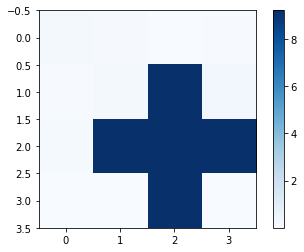

In [4]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 2) Applying 2D FT (Fourier domain)

In [5]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 34.17154  +30.986097j  -20.310837 -18.195616j    6.5888906 +6.168578j
  -20.347675 -18.998163j ]
 [-19.987907 -18.547026j    7.504198  +6.2832947j   6.8817472 +6.3217983j
    6.68754   +6.3137617j]
 [  6.9671717 +6.16261j     6.9046736 +5.765152j  -20.43443  -18.609919j
    6.9259677 +6.6098223j]
 [-19.966219 -18.662254j    6.713642  +6.098993j    6.8967175 +6.049613j
    7.5147557 +6.110649j ]]


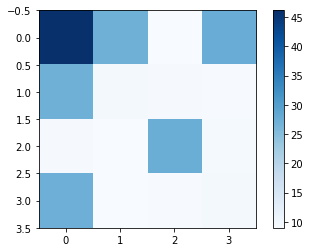

In [6]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

### Sanity check

In [7]:
img = np.fft.ifft2(visibilities).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()
 
print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 3.5850432e-15
Imaginaries MSE: 3.95242e-15


## 3) Data encoding: basis embedding (non-conventional domain)

In [8]:
# encoding binary data onto qubits
def encoding2(qc, binary, off_set):
    
    for i in range(0, len(binary)):
        qc.reset(off_set+i) # set quantum state |0> by default for all qubits

        if binary[i]=='1':
            qc.x(off_set+i) # act as a CX (controlled X gate)
    
    off_set += len(binary)

    return off_set

In [9]:
number_of_entries = visibilities.shape[0] * visibilities.shape[1]
number_of_bits_real = 32
number_of_bits_imag = 32
number_of_bits = number_of_bits_real + number_of_bits_imag
off_set = 0

# encoding (n bits encoded onto n qubits)
qc = QuantumCircuit(number_of_entries*number_of_bits)
for i in range(0, visibilities.shape[0]):
    for j in range(0, visibilities.shape[1]):
            binary_real = float_to_bin_real(visibilities[i, j].real)
            binary_imag = float_to_bin_imag(visibilities[i, j].imag)
            binary = binary_real+binary_imag
            off_set = encoding2(qc, binary, off_set)

# measurement
qc.measure_all()
backend = Aer.get_backend('aer_simulator') # Qiskit's staple simulator (CHOICE MOTIVATION?)
job = backend.run(qc, shots=1, memory=True) 
output = job.result().get_memory()[0]
out = reverse(output)

# readout
chunks_real = []
chunks_imag = []
for i in range(0, number_of_entries):
    chunks_real.append(out[number_of_bits*i:(number_of_bits*i)+number_of_bits_real]) # real parts represented every 64 bits starting from the first one
    chunks_imag.append(out[(number_of_bits*i)+number_of_bits_imag:(number_of_bits*i)+number_of_bits_imag+number_of_bits_imag]) # imaginary parts represented every 64 bits starting after the first occurence of a real part 

readout = []
for i in range(0, len(chunks_real)):
    readout.append(complex(bin_to_float_real(chunks_real[i]), bin_to_float_imag(chunks_imag[i]))) 

readout = np.array(readout).reshape(n , n).astype('complex64')
print(readout)

[[ 34.17154  +30.986097j  -20.310837 -18.195616j    6.5888906 +6.168578j
  -20.347675 -18.998163j ]
 [-19.987907 -18.547026j    7.504198  +6.2832947j   6.8817472 +6.3217983j
    6.68754   +6.3137617j]
 [  6.9671717 +6.16261j     6.9046736 +5.765152j  -20.43443  -18.609919j
    6.9259677 +6.6098223j]
 [-19.966219 -18.662254j    6.713642  +6.098993j    6.8967175 +6.049613j
    7.5147557 +6.110649j ]]


## 4) Applying 2D IFT (fidelity test)

In [10]:
img = np.fft.ifft2(readout).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 3.5850432e-15
Imaginaries MSE: 3.95242e-15


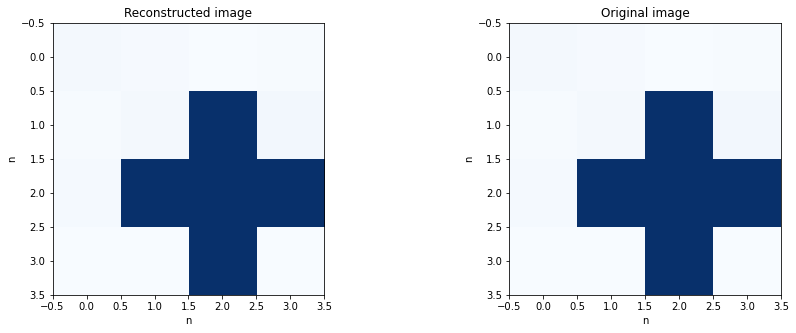

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(img)
modulus2 = np.absolute(sky_image)

axs[0].imshow(modulus1, cmap='Blues')
axs[1].imshow(modulus2, cmap='Blues')

axs[0].set_title("Reconstructed image")
axs[1].set_title("Original image")

for ax in axs.flat:
    ax.set(xlabel='n', ylabel='n')